# Quickstart

We used source code for skorch (https://skorch.readthedocs.io) to build our GPyTorch Wrapper

## Four steps to work with our GPyTorch Wrapper:
<b>1. Define a GP model </b>

<b>2. wrap the model into one of the following GPwrappers:</b>
    - ExactGaussianProcess (Use criterion = gpytorch.mlls.ExactMarginalLogLikelihood as default)
         - ExactGaussianProcessRegressor  (Use likelihood = GaussianLikelihood as default)
    - VariationalGaussianProcess (use criterion = gpytorch.mlls.VariationalMarginalLogLikelihood as default)
         - VariationalGaussianProcessRegressor (Use likelihood = GaussianLikelihood as default)
         - VariationalGaussianProcessClassifier (Use likelihood = BernoulliLikelihood as default)
<b>3. fit(x_train, y_train):</b>  # Find optimal model hyperparameters with default optimizer torch.optim.Adam

<b>4. predict_proba(x_test):</b>  # Return a GaussianRandomVariable as the predictive outputs for x_test

# Training a model

Below is the example for a simple Gaussian Process regression using GpyTorch :class:`.ExactGaussianProcessRegressor`

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from torch.autograd import Variable

from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import ExactGaussianProcessRegressor

torch.manual_seed(7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [2]:
# Step 1: Define the GP model
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [3]:
# Step 2: Wrap the model into our GP Wrapper
GP = ExactGaussianProcessRegressor(
    module = ExactGPModel,
    train_split = None,
)

# Step 3: Find optimal model hyperparameters
GP.fit(X=train_x, y=train_y)

# Step 4: Prediction
test_x = Variable(torch.linspace(0, 1, 51))
observed_pred = GP.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1       18.1162  0.0792
      2       16.5294  0.0592
      3       14.4397  0.0095
      4       11.9666  0.0144
      5        9.4068  0.0183
      6        7.1224  0.0155
      7        5.3722  0.0152
      8        4.2027  0.0152
      9        3.5067  0.0152
     10        3.1252  0.0145
     11        2.9252  0.0112
     12        2.8232  0.0143
     13        2.7746  0.0130
     14        2.7508  0.0123
     15        2.6336  0.0151
     16        2.6384  0.0130
     17        2.5950  0.0116
     18        2.7075  0.0084
     19        2.5385  0.0161
     20        2.5084  0.0187
     21        2.4774  0.0173
     22        2.5373  0.0231
     23        2.3017  0.0136
     24        2.4373  0.0173
     25        2.3779  0.0174
     26        2.2113  0.0179
     27        2.2468  0.0176
     28        2.1506  0.0109
     29        1.9888  0.0172
     30        1.8875  0.0132
     31        2.0765  0.0218
     32   

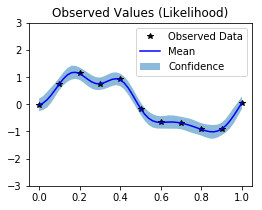

In [4]:
# (*) Step 5: Plotting
# Define plotting function
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

def ax_plot(ax, rand_var, title):
    # Get lower and upper predictive bounds
    lower, upper = rand_var.confidence_region()
    # Plot the training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GP),
])

pipe.fit(X=train_x.unsqueeze(-1), y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1        2.6198  0.0094
      2        2.6083  0.0148
      3        2.5034  0.0268
      4        2.5332  0.0188
      5        2.3453  0.0144
      6        2.1488  0.0181
      7        2.0856  0.0139
      8        1.8338  0.0125
      9        1.6801  0.0106
     10        1.6217  0.0114
     11        1.9302  0.0140
     12        1.8152  0.0147
     13        1.7589  0.0127
     14        2.0150  0.0109
     15        2.1317  0.0139
     16        2.2061  0.0128
     17        2.1506  0.0110
     18        2.1678  0.0112
     19        2.1327  0.0127
     20        2.2624  0.0123
     21        2.2076  0.0127
     22        2.3043  0.0102
     23        2.2372  0.0107
     24        2.2588  0.0095
     25        2.2315  0.0137
     26        2.0421  0.0146
     27        2.2243  0.0143
     28        2.1377  0.0131
     29        2.0736  0.0120
     30        2.1531  0.0150
     31        2.0016  0.0111
     32   

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.ExactGaussianProcessRegressor'>[initialized](
  module_=ExactGPModel(
    (likelihood): GaussianLikelihood()
    (mean_module): ConstantMean()
    (covar_module): RBFKernel()
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}
gs = GridSearchCV(GP, params, refit=False, cv=3, scoring='r2', 
                  return_train_score=False)  #  Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1       13.3963  0.0057
      2       13.2091  0.0092
      3       13.0196  0.0177
      4       12.8300  0.0143
      5       12.6380  0.0121
      6       12.4456  0.0096
      7       12.2508  0.0119
      8       12.0566  0.0115
      9       11.8613  0.0138
     10       11.6653  0.0070
  epoch    train_loss     dur
-------  ------------  ------
      1       19.1313  0.0097
      2       19.0124  0.0097
      3       18.8891  0.0120
      4       18.7615  0.0139
      5       18.6294  0.0113
      6       18.4924  0.0116
      7       18.3504  0.0135
      8       18.2032  0.0113
      9       18.0507  0.0107
     10       17.8927  0.0132
  epoch    train_loss     dur
-------  ------------  ------
      1       12.3479  0.0069
      2       12.2045  0.0090
      3       12.0610  0.0080
      4       11.9175  0.0095
      5       11.7764  0.0113
      6       11.6347  0.0124
      7       11.4933  0.0122
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`